## Transfer Learning mobilenetV2 using Tensorflow

Please download the dataset from the below url

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Fri Oct 28 14:44:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [4]:
# re-size all the images to this
IMAGE_SIZE = (224, 224)

train_path = '/content/drive/MyDrive/breakHis_project/covid dataset/train'
valid_path = '/content/drive/MyDrive/breakHis_project/covid dataset/val'
test_path = '/content/drive/MyDrive/breakHis_project/covid dataset/test'

In [7]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/breakHis_project/covid dataset/train/*')
folders

['/content/drive/MyDrive/breakHis_project/covid dataset/train/covid',
 '/content/drive/MyDrive/breakHis_project/covid dataset/train/normal',
 '/content/drive/MyDrive/breakHis_project/covid dataset/train/pneumonia']

In [8]:
import os
covid_train = len(os.listdir(folders[0]))
normal_train = len(os.listdir(folders[1]))
pneumonia_train = len(os.listdir(folders[2]))
print(f"No of Covid files {covid_train}\nNo of Normal files {normal_train}\nNo of pneumonia files {pneumonia_train}")

No of Covid files 941
No of Normal files 941
No of pneumonia files 941


In [9]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

train_datagen = ImageDataGenerator(rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2823 images belonging to 3 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale = 1./255)
val_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 807 images belonging to 3 classes.


In [11]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 405 images belonging to 3 classes.


### Model

In [12]:
engine = tf.keras.applications.Xception(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,
        # Use Imagenet weights
        weights = 'imagenet',
        # Define input shape to 224x224x3
        input_shape = (224 , 224 , 3),
    )

83683744/83683744 [==============================] - 1s 0us/step


In [13]:
x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
x = tf.keras.layers.Dropout(0.75)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
prediction = Dense(len(folders), activation = 'softmax', name = 'dense_output')(x)
 # Build the Keras model
model = Model(inputs = engine.input, outputs = prediction)

In [14]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  # optimizer='adam',
  optimizer= Adam(learning_rate=0.001),
  metrics=['accuracy']
)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [18]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=val_set,
  epochs=20,
  callbacks=[early_stopping, reduce_lr , learning_rate_reduction]
)

Epoch 1/20
89/89 [==============================] - 2772s 31s/step - loss: 0.3585 - accuracy: 0.8824 - val_loss: 0.1705 - val_accuracy: 0.9393 - lr: 0.0010
Epoch 2/20
89/89 [==============================] - 61s 681ms/step - loss: 0.2097 - accuracy: 0.9306 - val_loss: 0.3737 - val_accuracy: 0.8885 - lr: 0.0010
Epoch 3/20
89/89 [==============================] - 60s 666ms/step - loss: 0.1968 - accuracy: 0.9338 - val_loss: 0.1651 - val_accuracy: 0.9430 - lr: 0.0010
Epoch 4/20
89/89 [==============================] - 59s 659ms/step - loss: 0.1378 - accuracy: 0.9529 - val_loss: 0.3081 - val_accuracy: 0.9046 - lr: 0.0010
Epoch 5/20
89/89 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9423
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
89/89 [==============================] - 59s 664ms/step - loss: 0.1734 - accuracy: 0.9423 - val_loss: 0.8301 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 6/20
89/89 [==============================] - 59s 659ms

In [19]:
import matplotlib.pyplot as plt

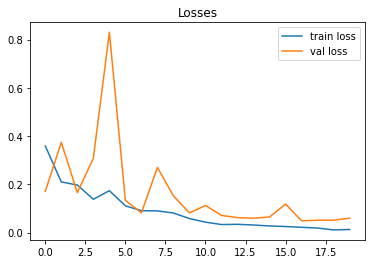

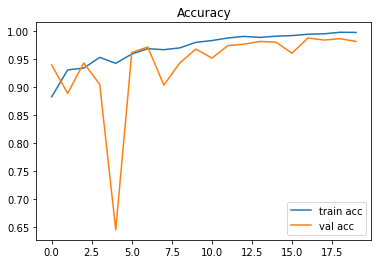

<Figure size 432x288 with 0 Axes>

In [20]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')
plt.show()
plt.savefig('LossVal_loss')
print()
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.savefig('AccVal_acc')

In [21]:
# average training accuracy
np.mean(r.history['accuracy'])

0.9701381534337997

In [22]:
# val accuracy
model.evaluate(val_set)

26/26 [==============================] - 4s 140ms/step - loss: 0.0594 - accuracy: 0.9814


[0.05935772508382797, 0.9814126491546631]

In [23]:
# test accuracy
model.evaluate(test_set)

13/13 [==============================] - 279s 23s/step - loss: 0.1038 - accuracy: 0.9728


[0.10377394407987595, 0.9728395342826843]

In [24]:
test_set.class_indices

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
prob = model.predict(test_set)
print(prob)

13/13 [==============================] - 5s 248ms/step
[[9.9999607e-01 3.9327601e-06 5.5175503e-10]
 [9.9978751e-01 2.1011566e-04 2.3412010e-06]
 [9.9999881e-01 1.4333399e-07 1.0247943e-06]
 ...
 [1.8004940e-07 6.9878179e-06 9.9999285e-01]
 [4.3949167e-05 1.3930967e-01 8.6064637e-01]
 [6.2878570e-07 4.6176130e-05 9.9995315e-01]]


In [26]:
predIdxs = np.argmax(prob, axis=1) 

print('\n')
print(classification_report(test_set.labels, predIdxs,target_names = ['COVID','Normal','Viral Pneumonia'], digits=5))



                 precision    recall  f1-score   support

          COVID    0.98519   0.98519   0.98519       135
         Normal    0.96970   0.94815   0.95880       135
Viral Pneumonia    0.96377   0.98519   0.97436       135

       accuracy                        0.97284       405
      macro avg    0.97288   0.97284   0.97278       405
   weighted avg    0.97288   0.97284   0.97278       405



In [27]:

y_true = test_set.labels
y_pred = predIdxs
cm=confusion_matrix(y_true,y_pred)
cm

array([[133,   2,   0],
       [  2, 128,   5],
       [  0,   2, 133]])

Text(69.0, 0.5, 'Predicted Values')

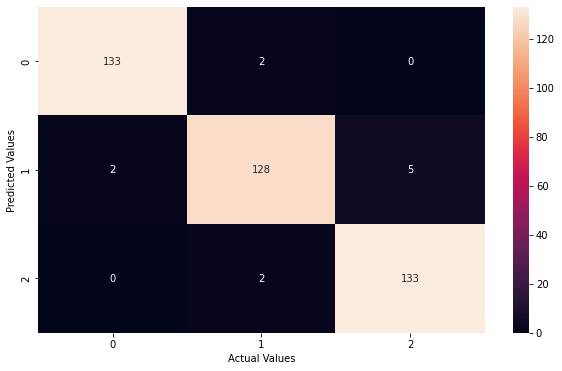

In [28]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [29]:
from sklearn.metrics import accuracy_score, f1_score,matthews_corrcoef,make_scorer, precision_score, recall_score, balanced_accuracy_score
score=accuracy_score(y_true,y_pred)
# scorers = {
#             'f1_score': make_scorer(f1_score, average='micro'),
#             # 'precision_score': make_scorer(precision_score, average='micro'),
#             # 'recall_score': make_scorer(recall_score, average='micro'),
#             'accuracy_score': make_scorer(accuracy_score)
# }
f1 = f1_score(y_true, y_pred,  average='micro')
pre = precision_score(y_true, y_pred,  average='micro')
recall = recall_score(y_true, y_pred,  average='micro')
acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true,y_pred)
# print(f"accuracy {score} f1 {f1} mcc {mcc}")

print(f1, pre, recall, acc,mcc)

0.9728395061728395 0.9728395061728395 0.9728395061728395 0.9728395061728395 0.9593382203870433


In [30]:
# # save it as a h5 file
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model.save('Transfer_Learning_covid_mobilenetV2.h5')

In [31]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model=load_model('/content/Transfer_Learning_covid_mobilenetV2.h5')

In [32]:
img=image.load_img('/content/drive/MyDrive/breakHis_project/covid dataset/test/covid/COVID-1126.png',target_size=(224,224))
x=image.img_to_array(img)
x=x/255
x.shape

(224, 224, 3)

In [33]:
# # from keras.applications.xception import preprocess_input
# import numpy as np
# x=np.expand_dims(x,axis=0)
# img_data=preprocess_input(x)
# img_data.shape

In [34]:
img_data = x.reshape(1,224,224,3)

In [35]:
result = model.predict(img_data)
result = np.argmax(result, axis=-1)
result

1/1 [==============================] - 1s 1s/step


array([0])

In [36]:
a=np.argmax(model.predict(img_data), axis=1)
a

1/1 [==============================] - 0s 30ms/step


array([0])

In [37]:
a==0 # 0 = covid, 1 = normal, 2= Pneumonia

array([ True])

In [38]:
img_path = '/content/drive/MyDrive/breakHis_project/covid dataset/test/pneumonia/Viral Pneumonia-120.png'

category = img_path.split('/')[-1].split('-')[0].upper()
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'VIRAL PNEUMONIA':
    true = 'Viral Pneumonia'
else:
    true = 'Normal'
print(f'True value is : {true}')

True value is : Viral Pneumonia


1/1 [==============================] - 0s 20ms/step
[2]
Prediction is:
Viral Pneumonia 


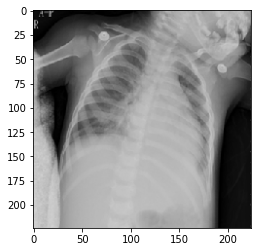

In [39]:
image = load_img(img_path, target_size=(224, 224))
img = img_to_array(image)/255
img = img.reshape((1, 224, 224, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print(result)
print('Prediction is:')
if result == 0:
    print("COVID")
elif result == 1:
    print("Normal")
else:
    print("Viral Pneumonia ")
    
plt.imshow(image)

In [ ]:
# covid = 0
# normal = 0
# pneumonia = 0

# directory = r'/content/drive/MyDrive/breakHis_project/covid dataset/test/normal'
# files = os.listdir(directory)

# for i, file in enumerate(files):
#     img_path = os.path.join(directory, file)


# # img_path = '/content/drive/MyDrive/breakHis_project/covid dataset/test/pneumonia/Viral Pneumonia-120.png'

#     category = img_path.split('/')[-1].split('-')[0].upper()
#     true = ''
#     if category == 'COVID':
#         true = 'COVID'
#     elif category == 'VIRAL PNEUMONIA':
#         true = 'Viral Pneumonia'
#     else:
#         true = 'Normal'
#     print(f'True value is : {true}')

#     image = load_img(img_path, target_size=(224, 224))
#     img = img_to_array(image)/255
#     img = img.reshape((1, 224, 224, 3))

#     result = model.predict(img)
#     result = np.argmax(result, axis=-1)
#     print(result)
#     print('Prediction is:')
#     if result == 0:
#         print("COVID")
#         covid = covid+ 1
#     elif result == 1:
#         print("Normal")
#         normal = normal+ 1
#     else:
#         print("Viral Pneumonia ")
#         pneumonia = pneumonia+ 1
        
#     # plt.imshow(image)
# print(f"Covid {covid} normal {normal} pneumonia {pneumonia}")

In [ ]:
# import os
# import numpy as np

# # Keras
# from tensorflow.keras.applications.imagenet_utils import preprocess_input
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image

# # Model saved with Keras model.save()
# MODEL_PATH = r'/content/Transfer_Learning_covid_mobilenetV2.h5'

# # Load your trained model
# model = load_model(MODEL_PATH)
# model.make_predict_function()

# directory = r'/content/drive/MyDrive/breakHis_project/covid dataset/test/normal'
# files = os.listdir(directory)
# len(files)

In [ ]:
# pre = list()
# covid = 0
# normal = 0
# pneumonia = 0
# for i, file in enumerate(files):
#     img_path = os.path.join(directory, file)
#     img = image.load_img(img_path, target_size=(224, 224))
    
#     # Preprocessing the image
#     x = image.img_to_array(img)
#     # x = np.true_divide(x, 255)
#     x = np.expand_dims(x, axis=0)
    
#     # Be careful how your trained model deals with the input
#     # otherwise, it won't make correct prediction!
#     # x = preprocess_input(x)
    
#     preds = model.predict(x) # 'covid': 0, 'normal': 1, 'pneumonia': 2
#     pred_class = preds.argmax(axis=-1) 
#     pre.append(list(pred_class))
    
#     if pre[i][0] == 0:
#         result = "Covid"
#         covid = covid+ 1
#     if pre[i][0] == 1:
#         result = "Normal"
#         normal = normal + 1
#     if pre[i][0] == 1:
#         result = "Pneumonia"
#         pneumonia = pneumonia + 1
# print(f"Covid {covid} normal {normal} pneumonia {pneumonia}")